In [1]:
loan <- read.csv("loan.csv", stringsAsFactors = FALSE)
loanT <- loan

In [2]:
# First think about what features could be included in the model
# i.e., what features would be available during model building. Work example.
# e.g., loan payment features will not be available when deciding interest rate.

In [3]:
# Second think about what features should be included in the model
# i.e., Remove features using intuition, Remove features with unique value per row or no variance. 
#       Remove redundant features
# e.g., id, member.id

Remove redundant column

In [4]:
num.value <- sapply(loan, function(x){return(length(unique(x)))})


In [5]:
which(num.value == 1)
#features with no variance

policy_code 
         52

In [6]:
which(num.value == dim(loan)[1])
#features with unique value per row 

id member_id       url 
        1         2        19

In [7]:
summary(loan$dti_joint)#too much NA value

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    3.0    13.2    17.6    18.3    22.6    43.9  886870 

transform some column

In [8]:
with(subset(loan, is.na(dti_joint)), table(application_type))#to check what is the application type of dit_joint which has too much NA value

application_type
INDIVIDUAL      JOINT 
    886868          2 

In [9]:
loan$dti <- ifelse(!is.na(loan$dti_joint), loan$dti_joint, loan$dti)#we want to change the value of dti_joint with NA to the value of dti
#if the value dti_joint is NA, we will change it to the value of dti. If not, keep the origin dti_joint value

In [10]:
loan$annual_inc <- ifelse(!is.na(loan$annual_inc_joint), loan$annual_inc_joint, loan$annual_inc)#same way with annual_inc_joint

In [11]:
loan$home_ownership <- ifelse(loan$home_ownership %in% c('ANY', 'NONE', 'OTHER'), 'OTHER',
                              loan$home_ownership)

In [12]:
#addr_state has too many levels. collapse it to less levels
int_state <- by(loan, loan$addr_state, function(x) {return(mean(x$int_rate))})

In [14]:
#new column generated for state address using quantile of 
loan$state_mean_int <- ifelse(loan$addr_state %in% names(int_state)[which(int_state <= quantile(loan$int_rate,0.25))],'low',
                             ifelse(loan$addr_state %in% names(int_state)[which(int_state <= quantile(loan$int_rate,0.5))],'low_medium',
                                    ifelse(loan$addr_state %in% names(int_state)[which(int_state <= quantile(loan$int_rate,0.75))],'medium_high','high')))

In [15]:
#filter the columns which has more than 80% missing values
num.NA <- sort(sapply(loan, function(x) { sum(is.na(x))} ), decreasing = TRUE)
remain.col <- names(num.NA)[which(num.NA <= 0.8 * dim(loan)[1])]
loan <- loan[, remain.col]

In [16]:
#transform time format data using zoo library
library(zoo)
loan$issue_d_1 <- as.Date(as.yearmon(loan$issue_d, "%b-%Y"))
loan$issue_year <- as.character(format(loan$issue_d_1, "%Y"))
loan$issue_mon <- as.character(format(loan$issue_d_1, "%m"))

Warning message:
"package 'zoo' was built under R version 3.4.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



In [17]:
#before modeling, we need split the data into train and test
set.seed(1)
train.ind <- sample(1:dim(loan)[1], 0.7 * dim(loan)[1])
train <- loan[train.ind, ]
test <- loan[-train.ind, ]

In [18]:
#build a linear regression model without any transformation
mod1 <- lm(int_rate ~ addr_state + home_ownership + annual_inc + dti +
             + term + loan_amnt + total_acc + tot_cur_bal + open_acc,
           data = train)
summary(mod1)


Call:
lm(formula = int_rate ~ addr_state + home_ownership + annual_inc + 
    dti + +term + loan_amnt + total_acc + tot_cur_bal + open_acc, 
    data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.3577  -2.9917  -0.2061   2.4304  26.3058 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.199e+01  1.045e-01 114.670  < 2e-16 ***
addr_stateAL         1.551e-01  1.124e-01   1.379 0.167885    
addr_stateAR        -1.424e-01  1.186e-01  -1.200 0.229964    
addr_stateAZ        -2.922e-01  1.081e-01  -2.703 0.006869 ** 
addr_stateCA        -1.403e-01  1.036e-01  -1.354 0.175664    
addr_stateCO        -4.045e-01  1.086e-01  -3.726 0.000194 ***
addr_stateCT        -1.890e-01  1.110e-01  -1.703 0.088528 .  
addr_stateDC        -3.137e-01  1.447e-01  -2.167 0.030201 *  
addr_stateDE        -1.237e-01  1.410e-01  -0.877 0.380228    
addr_stateFL        -1.638e-01  1.046e-01  -1.566 0.117239    
addr_stateGA        -1.723e-

In [19]:
#use transformed features to build the model
mod2 <- lm(int_rate ~ state_mean_int + home_ownership + annual_inc + dti +
             + term + loan_amnt + total_acc + tot_cur_bal + open_acc,
           data = train)
summary(mod2)


Call:
lm(formula = int_rate ~ state_mean_int + home_ownership + annual_inc + 
    dti + +term + loan_amnt + total_acc + tot_cur_bal + open_acc, 
    data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.2289  -2.9918  -0.2044   2.4324  26.5898 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.130e+01  3.029e-02 372.998  < 2e-16 ***
state_mean_intmedium_high  4.888e-01  2.412e-02  20.265  < 2e-16 ***
home_ownershipOTHER        2.788e+00  4.933e-01   5.653 1.58e-08 ***
home_ownershipOWN          2.042e-01  1.825e-02  11.186  < 2e-16 ***
home_ownershipRENT         5.528e-01  1.277e-02  43.302  < 2e-16 ***
annual_inc                -2.264e-06  8.974e-08 -25.233  < 2e-16 ***
dti                        6.716e-02  6.684e-04 100.482  < 2e-16 ***
term 60 months             4.154e+00  1.236e-02 336.204  < 2e-16 ***
loan_amnt                  4.808e-06  7.287e-07   6.597 4.19e-11 ***
total_acc                 -

In [20]:
#r-squared value indicates the information in the new model does not decrease

In [21]:
#to simplify, save all features in a training subset
train.sub <- train[, c('int_rate', 'state_mean_int', 'home_ownership', 'annual_inc', 'dti',
                       'term', 'loan_amnt', 'total_acc', 'tot_cur_bal', 'open_acc')]

In [24]:
#we notice the new linear regression model shows some observations deleted due to missingness. Now, we will impute the missing value using median value
num.NA <- sort(sapply(train.sub, function(x) {sum(is.na(x))}))
num.NA

int_rate state_mean_int home_ownership            dti           term 
             0              0              0              0              0 
     loan_amnt     annual_inc      total_acc       open_acc    tot_cur_bal 
             0              2             18             18          49104

In [25]:
train.sub$tot_cur_bal[which(is.na(train.sub$tot_cur_bal))] <- median(train.sub$tot_cur_bal, na.rm = T)
train.sub$total_acc[which(is.na(train.sub$total_acc))] <- median(train.sub$total_acc, na.rm = T)
train.sub$open_acc[which(is.na(train.sub$open_acc))] <- median(train.sub$open_acc, na.rm = T)
train.sub$annual_inc[which(is.na(train.sub$annual_inc))] <- median(train.sub$annual_inc, na.rm = T)

In [41]:
mod2 <- lm(int_rate ~ ., data = train.sub)
summary(mod2)


Call:
lm(formula = int_rate ~ ., data = train.sub)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.2735  -2.9908  -0.1842   2.4361  24.1188 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.109e+01  2.866e-02 386.918  < 2e-16 ***
state_mean_intmedium_high  4.699e-01  2.290e-02  20.514  < 2e-16 ***
home_ownershipOTHER        1.758e+00  3.073e-01   5.721 1.06e-08 ***
home_ownershipOWN          2.013e-01  1.752e-02  11.492  < 2e-16 ***
home_ownershipRENT         5.487e-01  1.200e-02  45.726  < 2e-16 ***
annual_inc                -1.938e-06  8.581e-08 -22.590  < 2e-16 ***
dti                        6.903e-02  6.409e-04 107.714  < 2e-16 ***
term 60 months             4.094e+00  1.184e-02 345.635  < 2e-16 ***
loan_amnt                  1.368e-05  6.962e-07  19.649  < 2e-16 ***
total_acc                 -2.417e-02  5.923e-04 -40.805  < 2e-16 ***
tot_cur_bal               -2.225e-06  4.217e-08 -52.769  < 2e-16 ***
o

In [27]:
# See extremely small estimate, e.g., loan_amnt, because of the magnitude, to compare the relative importance of features
# Standardize
train.sub.scale <- train.sub
train.sub.scale[, c(4,5,7,8,9,10)] <- scale(train.sub.scale[, c(4,5,7,8,9,10)])

In [28]:
mod3 <- lm(int_rate ~ ., data = as.data.frame(train.sub.scale))
# standardizing won't change the significant of features, but the estimate will change.

In [29]:
#transform data frame to matrix
train.sub.matrix <- model.matrix( ~., train.sub)
head(train.sub.matrix)

,(Intercept),int_rate,state_mean_intmedium_high,home_ownershipOTHER,home_ownershipOWN,home_ownershipRENT,annual_inc,dti,term 60 months,loan_amnt,total_acc,tot_cur_bal,open_acc
235607,1,8.19,1,0,0,0,128941,31.83,0,28000,33,530944,23
330215,1,22.15,1,0,0,0,100000,12.82,1,14000,29,146665,15
508337,1,7.26,1,0,0,0,50000,24.96,0,6000,23,140834,12
805922,1,12.29,1,0,0,1,75000,24.06,0,12500,44,214499,19
178968,1,21.98,0,0,0,1,48000,16.70,1,20000,16,17999,7
797208,1,6.68,1,0,0,0,55000,17.61,0,7000,17,144220,9


In [30]:
#set response and features
x <- train.sub.matrix[, -2]
y <- train.sub.matrix[, 2]

In [31]:
# to calculate the XT*X
t(x) %*% x

,(Intercept),state_mean_intmedium_high,home_ownershipOTHER,home_ownershipOWN,home_ownershipRENT,annual_inc,dti,term 60 months,loan_amnt,total_acc,tot_cur_bal,open_acc
(Intercept),621165,591283,158.00,61345,248996,4.666748e+10,1.125695e+07,186149,9.165597e+09,1.570417e+07,8.382327e+10,7.175377e+06
state_mean_intmedium_high,591283,591283,145.00,58840,236433,4.441480e+10,1.072680e+07,176973,8.714262e+09,1.494382e+07,7.955466e+10,6.830181e+06
home_ownershipOTHER,158,145,158.00,0,0,1.014063e+07,2.492080e+03,11,1.831000e+06,3.591000e+03,1.504649e+07,1.550000e+03
home_ownershipOWN,61345,58840,0.00,61345,0,4.234989e+09,1.160115e+06,17120,8.717899e+08,1.525509e+06,6.438124e+09,7.030250e+05
home_ownershipRENT,248996,236433,0.00,0,248996,1.594494e+10,4.490158e+06,60486,3.209381e+09,5.545703e+06,1.340116e+10,2.677388e+06
annual_inc,46667477295,44414804592,10140630.00,4234989452,15944942889,6.208633e+15,7.860265e+11,15072552850,8.017946e+14,1.269218e+12,8.704594e+15,5.687926e+11
dti,11256947,10726797,2492.08,1160115,4490158,7.860265e+11,2.467653e+08,3624696,1.679767e+11,2.984294e+08,1.520176e+12,1.382995e+08
term 60 months,186149,176973,11.00,17120,60486,1.507255e+10,3.624696e+06,186149,3.736957e+09,5.051200e+06,2.978264e+10,2.280544e+06
loan_amnt,9165596525,8714262125,1831000.00,871789850,3209381350,8.017946e+14,1.679767e+11,3736957000,1.794269e+14,2.455211e+11,1.488701e+15,1.114063e+11
total_acc,15704173,14943820,3591.00,1525509,5545703,1.269218e+12,2.984294e+08,5051200,2.455211e+11,4.842607e+08,2.451397e+12,2.086394e+08


In [32]:
# note that X dim is n * (p+1), XT*X dim is (p+1) * (p+1)
# inverse
xtxi <- solve(t(x) %*% x)
# beta estimator
xtxi %*% t(x) %*% y

(Intercept),1.108841e+01
state_mean_intmedium_high,4.698675e-01
home_ownershipOTHER,1.758313e+00
home_ownershipOWN,2.013172e-01
home_ownershipRENT,5.486982e-01
annual_inc,-1.938379e-06
dti,6.903477e-02
term 60 months,4.093992e+00
loan_amnt,1.368054e-05
total_acc,-2.417001e-02
tot_cur_bal,-2.225317e-06


In [42]:
# compare with model fitted coefficient
coef(mod2)

(Intercept) state_mean_intmedium_high       home_ownershipOTHER 
             1.108841e+01              4.698675e-01              1.758313e+00 
        home_ownershipOWN        home_ownershipRENT                annual_inc 
             2.013172e-01              5.486982e-01             -1.938379e-06 
                      dti            term 60 months                 loan_amnt 
             6.903477e-02              4.093992e+00              1.368054e-05 
                total_acc               tot_cur_bal                  open_acc 
            -2.417001e-02             -2.225317e-06             -1.342060e-02

In [43]:
# sigma estimator, there are 13 features in total, plus beta0
head(mod2$res)


235607     330215     508337     805922     178968     797208 
-3.4109695  6.8436313 -4.9761914  0.2922201  5.4361691 -5.2305215

In [44]:
#Residual standard error
sqrt(sum(mod2$res^2)/(dim(train.sub)[1] - 14)) 

[1] 3.86167

In [45]:
# R square: 1 - sum_square_residual / sum_square_total
1 - sum(mod2$res^2)/sum((y-mean(y))^2)

[1] 0.2236609

In [46]:
# adjusted R square
1 - (sum(mod2$res^2)/sum((y-mean(y))^2)) * 
  (dim(train.sub)[1] - 1) /(dim(train.sub)[1] - 13 - 1)
# small p, R square adjusted is very similar to R square.

[1] 0.2236446

In [47]:
#F-test
sst = sum((y - mean(y))^2) # sum of square total, df = n - 1 = 572060
ssr = sum(mod2$res^2) #  sum of square residual, df = n-1-p = 572047
ssm = sum((y - mean(y))^2) - sum(mod2$res^2) # sum of square model, df = 13

In [50]:
Fstats = (ssm)/(13) / (ssr / (dim(train.sub)[1] - 13 -1))
Fstats

[1] 13765.51

In [49]:
1 - pf(Fstats, 13, (dim(train.sub)[1] - 13 - 1)) # def = p and n-1-p

[1] 0

In [51]:
#residue diagonosis
# residual = observed - fitted
head(sort(mod2$res))

625277    331615    168996    288534    689462    879300 
-12.27346 -11.90893 -11.85968 -11.74741 -11.63606 -11.37612

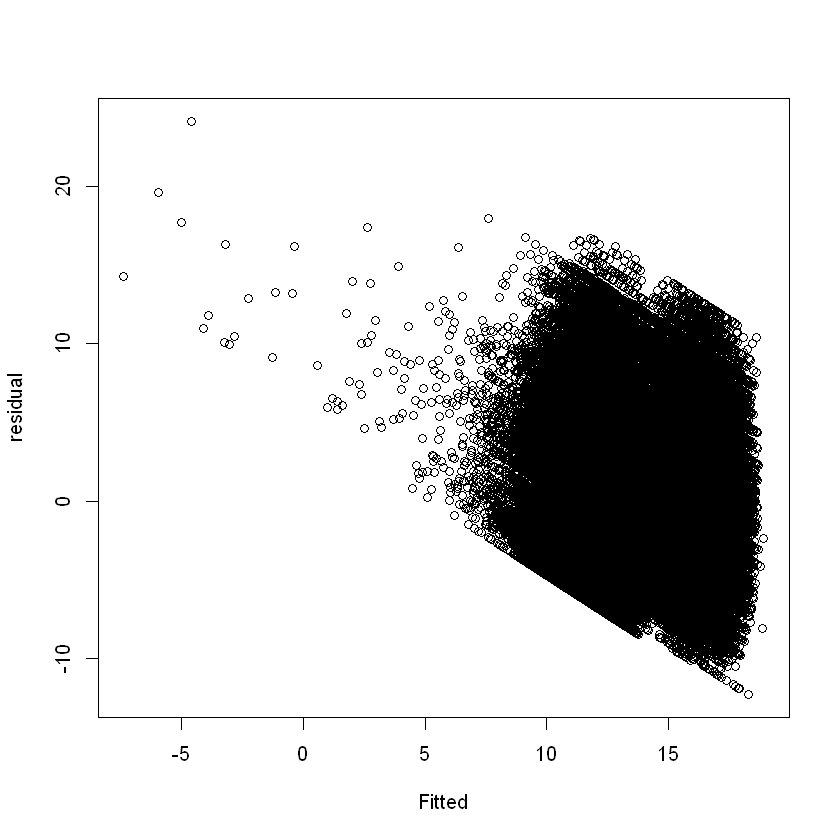

In [52]:
plot(mod2$fit, mod2$res, xlab = 'Fitted', ylab = 'residual')

In [53]:
# See data points with negative fitted value, we should not predict negative interest rate
mod2_1 <- lm(log(int_rate) ~ state_mean_int + home_ownership + annual_inc + dti +
             + term + loan_amnt + total_acc + tot_cur_bal + open_acc,
           data = train.sub)

In [54]:
# fitted or predicted interest rate
summary(exp(mod2_1$fitted.values))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.13   11.13   11.89   12.67   14.50   19.78 

In [55]:
summary(mod2_1$residuals)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.13312 -0.21440  0.02975  0.00000  0.21693  1.98252 

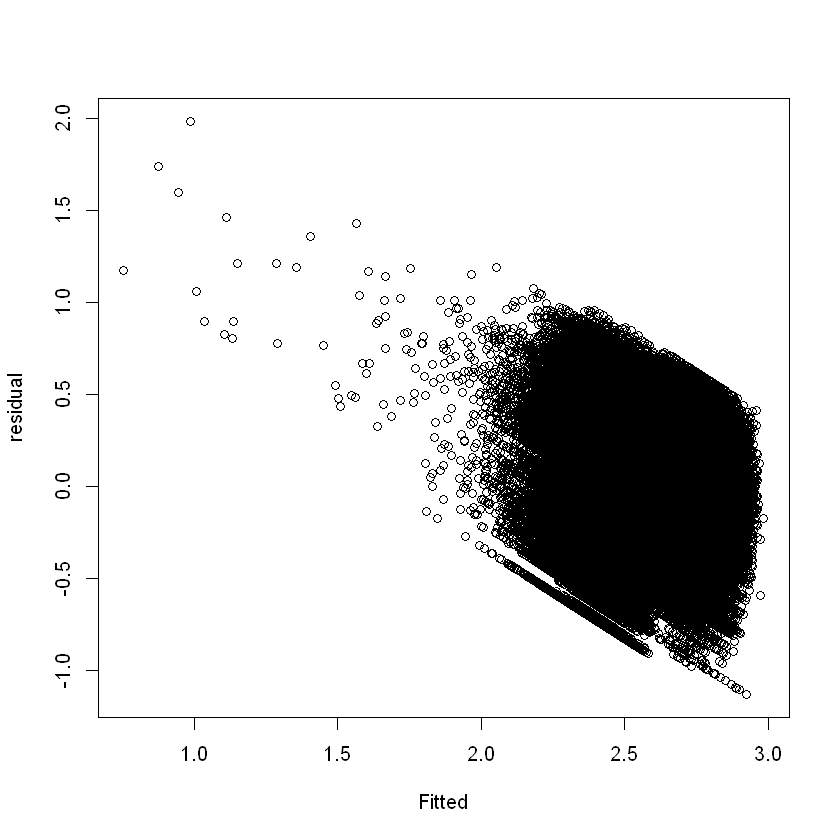

In [56]:
plot(mod2_1$fit, mod2_1$res, xlab = 'Fitted', ylab = 'residual')

In [57]:
# still large residuals for some data points. Check the reason.
cbind(train.sub[which(mod2_1$fitted <= 1.5), ],
      pred = round(exp(predict(mod2_1, train.sub[which(mod2_1$fitted <= 1.5), ])), 2))

,int_rate,state_mean_int,home_ownership,annual_inc,dti,term,loan_amnt,total_acc,tot_cur_bal,open_acc,pred
506741,6.89,medium_high,MORTGAGE,9000000,0.08,36 months,11000,29,324692,15,2.13
552198,12.69,medium_high,OWN,8253000,0.14,36 months,30000,26,130006,18,2.57
30177,12.73,medium_high,MORTGAGE,6000000,0.01,36 months,5000,10,80819,2,3.89
306812,7.69,medium_high,MORTGAGE,4900000,0.11,36 months,15600,26,130235,13,4.45
451988,7.62,medium_high,RENT,7446395,0.13,36 months,20000,24,31691,10,3.12
490863,10.64,medium_high,MORTGAGE,8700000,0.18,60 months,14000,32,89277,20,3.17
675610,7.89,medium_high,MORTGAGE,6000000,0.16,36 months,4475,13,401544,4,3.64
177183,13.11,medium_high,MORTGAGE,7141778,0.25,36 months,14825,31,69548,17,3.04
169236,12.12,medium_high,MORTGAGE,6100000,0.22,36 months,30000,19,329254,8,3.62
177928,15.80,medium_high,MORTGAGE,800000,4.12,36 months,35000,14,4772549,12,4.07


In [58]:
#notice that the annnual income is too large so that predicted int_rate is too large
#two methods to solve this problem
#1.non-linear model
#2.categorize annual income to several group
#here, use non-linear model
mod2_2 <- lm(log(int_rate) ~ state_mean_int + home_ownership + log(annual_inc) + dti +
               + term + loan_amnt + total_acc + tot_cur_bal + open_acc,
             data = train.sub)

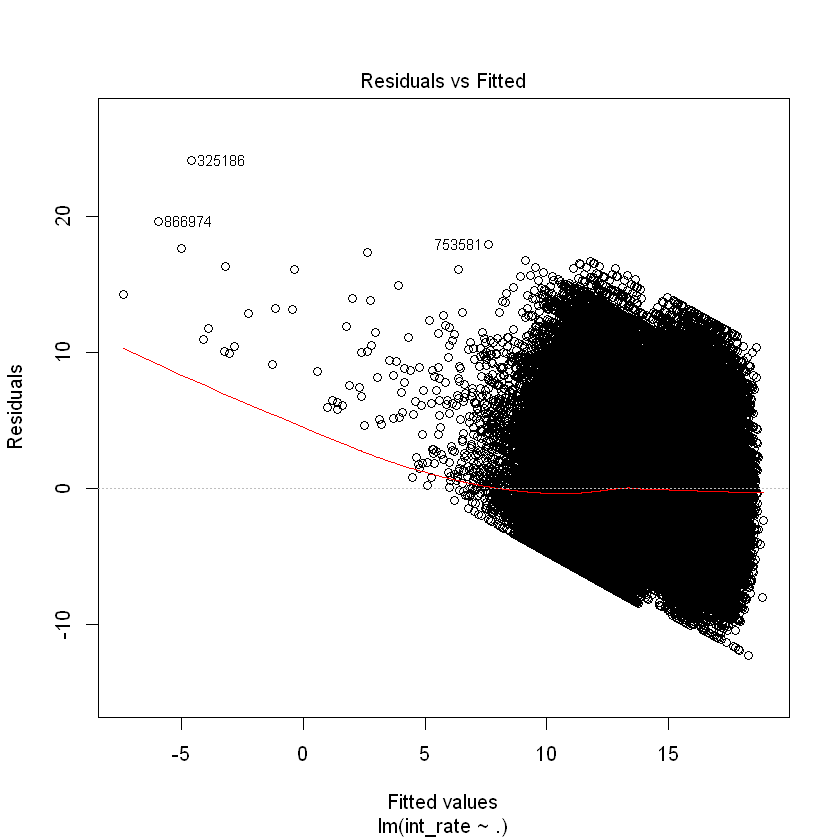

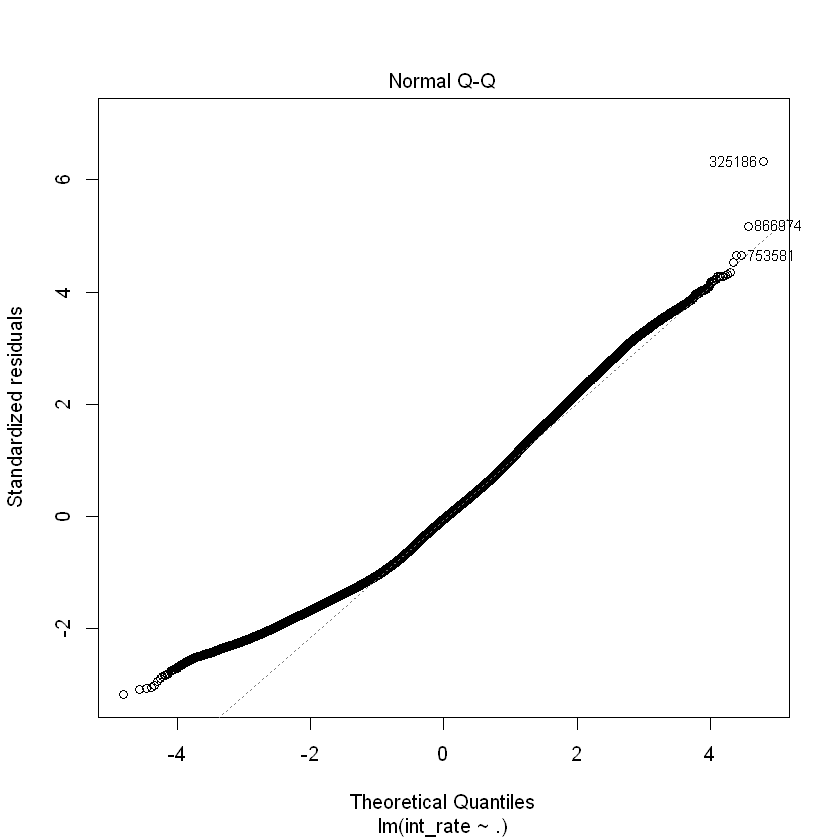

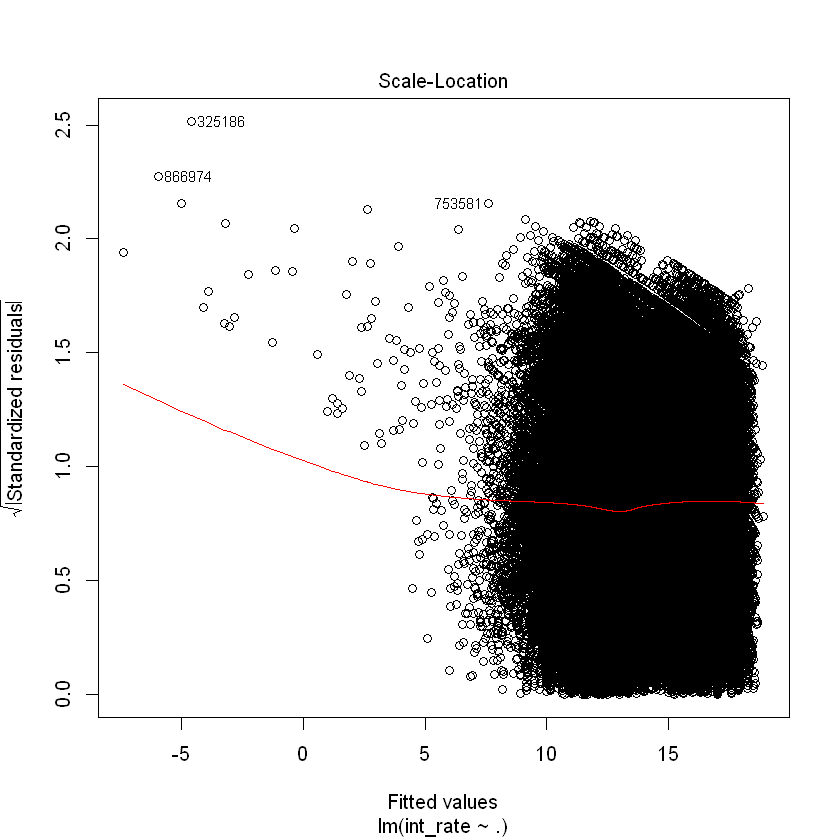

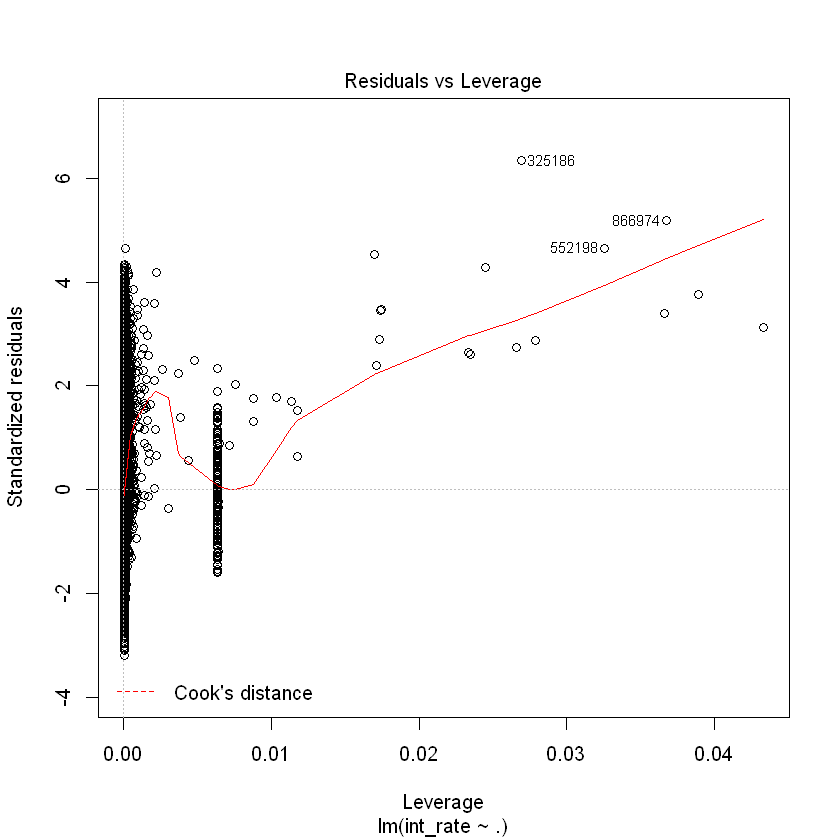

In [59]:
plot(mod2)
# first plot we can check unbiased/biased and homo/hetero of the residual
# Def not having homo, reason is model miss important features.
# second plot to check the normality of the residual. 
# qqplot: for ith percentile data point, find ith percentile in normal distribution.


In [ ]:
# collinearity
#do we need to solve all vollinearity issue
#not necessary
#if we just focus on the predicted value, we do not need to solve
#if we focus on the model interpreteration, we need to solve this issue.